# Base Model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

In [5]:
# load normalized data
path_years_norm = "/content/drive/MyDrive/FinalProject/sPINN/data/df_years_norm.csv"
path_days_norm  = "/content/drive/MyDrive/FinalProject/sPINN/data/df_days_norm.csv"

df_years_norm = pd.read_csv(path_years_norm)
df_days_norm  = pd.read_csv(path_days_norm)

In [6]:
# make sliding window dataset
def make_sliding_window(df, window_size, steps_ahead, target_col):
    # get features (everything except target)
    feature_cols = [c for c in df.columns if c != target_col]
    features = df[feature_cols].values.astype(float)

    # target values
    y_full = df[target_col].values.astype(float)

    X_list = []
    y_list = []

    # build sliding windows
    for i in range(len(features) - window_size - steps_ahead):
        window = features[i:i+window_size]
        target = y_full[i + window_size + steps_ahead]

        X_list.append(window)
        y_list.append(target)

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y


In [7]:
# years sliding window
window_size = 12
steps_ahead = 48 * 3   # 3 days ahead

X_years, y_years = make_sliding_window(
    df_years_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [8]:
# days sliding window
window_size = 12
steps_ahead = 48 * 3   # 3 days ahead

X_days, y_days = make_sliding_window(
    df_days_norm,
    window_size,
    steps_ahead,
    target_col="WVHT"
)

In [9]:
# plot the first window of a dataset
def plot_first_window(df, window_size, title_name):
    # get feature cols
    feature_cols = [c for c in df.columns]
    features = df[feature_cols].values.astype(float)

    # first window
    first_window = features[:window_size]

    # flip for plotting
    first_window_flipped = first_window.T

    # plot window
    plt.figure(figsize=(10, 6))
    plt.imshow(first_window_flipped, aspect="auto", cmap="viridis")
    plt.title(f"{title_name} Window ({first_window_flipped.shape[0]} features × {first_window_flipped.shape[1]} time steps)")
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.colorbar()
    plt.show()


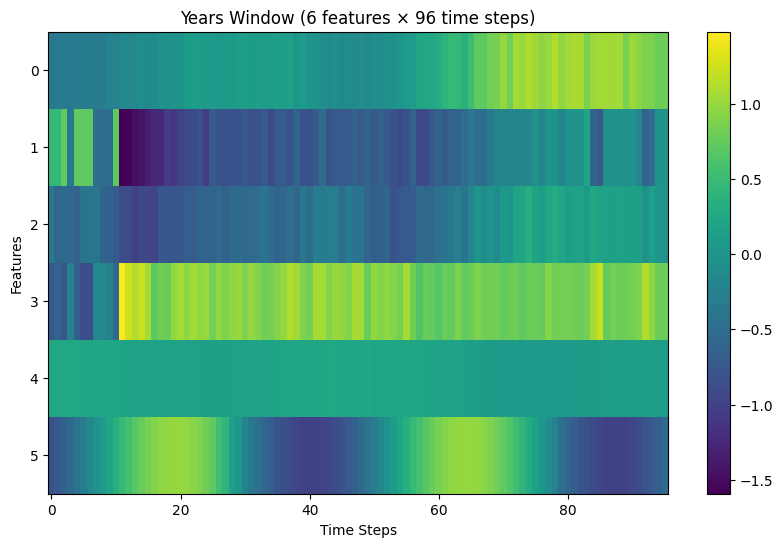

In [10]:
plot_first_window(df_years_norm, window_size=96, title_name="Years")

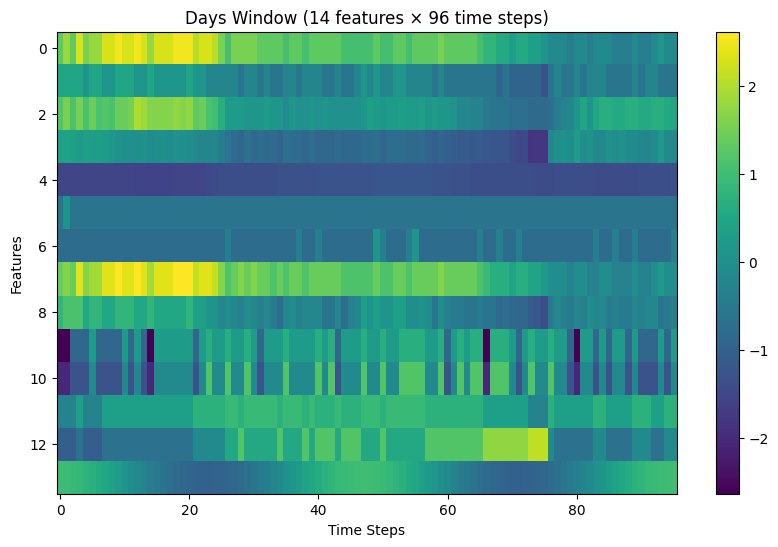

In [11]:
plot_first_window(df_days_norm, window_size=96, title_name="Days")


# MPL Multi Target (WVHT) Years Dataset

In [13]:
# feature cols (remove datetime)
feature_cols_years = [c for c in df_years_norm.columns if c not in ["datetime"]]

# remove time_sin from targets
target_cols_years = [c for c in feature_cols_years if c != "time_sin"]

# build index list for outputs
target_index_years = [feature_cols_years.index(c) for c in target_cols_years]

In [14]:
X_list_years = []
Y_list_years = []

features_years = df_years_norm[feature_cols_years].values.astype(float)
features_target_years = df_years_norm[target_cols_years].values.astype(float)

for i in range(len(features_years) - window_size - steps_ahead):
    window = features_years[i:i+window_size]
    target = features_target_years[i + window_size + steps_ahead]

    X_list_years.append(window)
    Y_list_years.append(target)

X_years_mt = np.array(X_list_years)   # (N, 7, num_features)
Y_years_mt = np.array(Y_list_years)   # (N, num_targets)

In [15]:
# flatten 7×num_features → vector
X_years_mt_flat = X_years_mt.reshape(X_years_mt.shape[0], -1)

# train/val split
X_train_years_mt, X_val_years_mt, Y_train_years_mt, Y_val_years_mt = train_test_split(
    X_years_mt_flat, Y_years_mt, test_size=0.2, shuffle=False
)

In [16]:
input_dim_years_mt = X_train_years_mt.shape[1]
output_dim_years_mt = Y_train_years_mt.shape[1]

model_years_mt = nn.Sequential(
    nn.Linear(input_dim_years_mt, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, output_dim_years_mt)
)

In [17]:
X_train_years_mt_t = torch.tensor(X_train_years_mt, dtype=torch.float32)
Y_train_years_mt_t = torch.tensor(Y_train_years_mt, dtype=torch.float32)

X_val_years_mt_t = torch.tensor(X_val_years_mt, dtype=torch.float32)
Y_val_years_mt_t = torch.tensor(Y_val_years_mt, dtype=torch.float32)

In [18]:
optimizer_years_mt = torch.optim.Adam(model_years_mt.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_losses_years_mt = []
val_losses_years_mt = []

for epoch in range(251):
    model_years_mt.train()
    optimizer_years_mt.zero_grad()

    pred = model_years_mt(X_train_years_mt_t)
    loss = loss_fn(pred, Y_train_years_mt_t)
    loss.backward()
    optimizer_years_mt.step()

    with torch.no_grad():
        val_pred = model_years_mt(X_val_years_mt_t)
        val_loss = loss_fn(val_pred, Y_val_years_mt_t)

    train_losses_years_mt.append(loss.item())
    val_losses_years_mt.append(val_loss.item())

    if epoch % 20 == 0:
        print(f"Years (multi-target) — Epoch {epoch}: train {loss.item():.4f}, val {val_loss.item():.4f}")

Years (multi-target) — Epoch 0: train 1.1008, val 0.6714
Years (multi-target) — Epoch 20: train 0.8636, val 0.4886
Years (multi-target) — Epoch 40: train 0.8588, val 0.4887
Years (multi-target) — Epoch 60: train 0.8550, val 0.4892
Years (multi-target) — Epoch 80: train 0.8519, val 0.4896
Years (multi-target) — Epoch 100: train 0.8484, val 0.4906
Years (multi-target) — Epoch 120: train 0.8441, val 0.4924
Years (multi-target) — Epoch 140: train 0.8389, val 0.4954
Years (multi-target) — Epoch 160: train 0.8332, val 0.4986
Years (multi-target) — Epoch 180: train 0.8277, val 0.5017
Years (multi-target) — Epoch 200: train 0.8225, val 0.5043
Years (multi-target) — Epoch 220: train 0.8177, val 0.5068
Years (multi-target) — Epoch 240: train 0.8130, val 0.5103


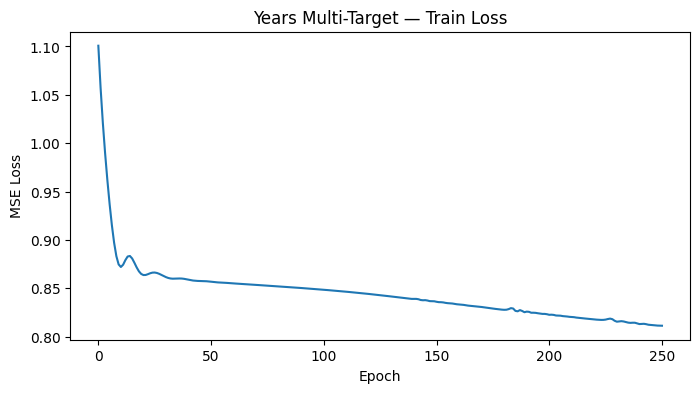

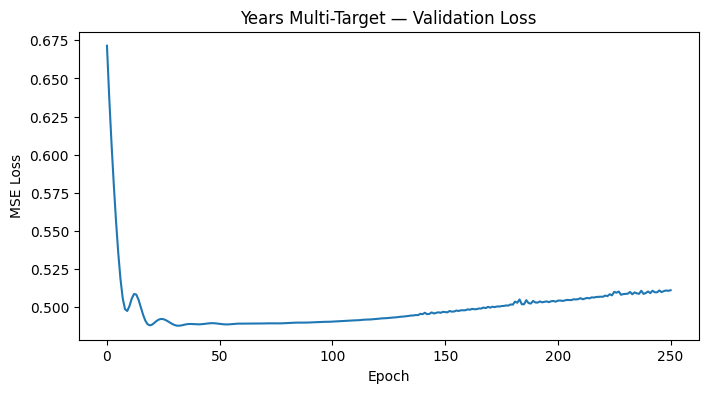

In [19]:
plt.figure(figsize=(8,4))
plt.plot(train_losses_years_mt)
plt.title("Years Multi-Target — Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_losses_years_mt)
plt.title("Years Multi-Target — Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

# MPL Multi Target (WVHT) Days Dataset

In [20]:
feature_cols_days = [c for c in df_days_norm.columns if c not in ["datetime"]]
target_cols_days = [c for c in feature_cols_days if c != "time_sin"]
target_index_days = [feature_cols_days.index(c) for c in target_cols_days]

In [21]:
X_list_days = []
Y_list_days = []

features_days = df_days_norm[feature_cols_days].values.astype(float)
features_target_days = df_days_norm[target_cols_days].values.astype(float)

for i in range(len(features_days) - window_size - steps_ahead):
    window = features_days[i:i+window_size]
    target = features_target_days[i + window_size + steps_ahead]

    X_list_days.append(window)
    Y_list_days.append(target)

X_days_mt = np.array(X_list_days)
Y_days_mt = np.array(Y_list_days)

In [22]:
X_days_mt_flat = X_days_mt.reshape(X_days_mt.shape[0], -1)

X_train_days_mt, X_val_days_mt, Y_train_days_mt, Y_val_days_mt = train_test_split(
    X_days_mt_flat, Y_days_mt, test_size=0.2, shuffle=False
)

In [23]:
input_dim_days_mt = X_train_days_mt.shape[1]
output_dim_days_mt = Y_train_days_mt.shape[1]

model_days_mt = nn.Sequential(
    nn.Linear(input_dim_days_mt, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, output_dim_days_mt)
)

In [24]:
X_train_days_mt_t = torch.tensor(X_train_days_mt, dtype=torch.float32)
Y_train_days_mt_t = torch.tensor(Y_train_days_mt, dtype=torch.float32)

X_val_days_mt_t = torch.tensor(X_val_days_mt, dtype=torch.float32)
Y_val_days_mt_t = torch.tensor(Y_val_days_mt, dtype=torch.float32)

In [25]:
optimizer_days_mt = torch.optim.Adam(model_days_mt.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_losses_days_mt = []
val_losses_days_mt = []

for epoch in range(251):
    model_days_mt.train()
    optimizer_days_mt.zero_grad()

    pred = model_days_mt(X_train_days_mt_t)
    loss = loss_fn(pred, Y_train_days_mt_t)
    loss.backward()
    optimizer_days_mt.step()

    with torch.no_grad():
        val_pred = model_days_mt(X_val_days_mt_t)
        val_loss = loss_fn(val_pred, Y_val_days_mt_t)

    train_losses_days_mt.append(loss.item())
    val_losses_days_mt.append(val_loss.item())

    if epoch % 20 == 0:
        print(f"Days (multi-target) — Epoch {epoch}: train {loss.item():.4f}, val {val_loss.item():.4f}")

Days (multi-target) — Epoch 0: train 1.0148, val 1.1212
Days (multi-target) — Epoch 20: train 0.6344, val 1.2268
Days (multi-target) — Epoch 40: train 0.4644, val 1.9257
Days (multi-target) — Epoch 60: train 0.3256, val 2.6505
Days (multi-target) — Epoch 80: train 0.2410, val 2.9854
Days (multi-target) — Epoch 100: train 0.1932, val 3.1463
Days (multi-target) — Epoch 120: train 0.1607, val 3.2701
Days (multi-target) — Epoch 140: train 0.1367, val 3.3248
Days (multi-target) — Epoch 160: train 0.1175, val 3.3655
Days (multi-target) — Epoch 180: train 0.1026, val 3.4325
Days (multi-target) — Epoch 200: train 0.0902, val 3.4594
Days (multi-target) — Epoch 220: train 0.0808, val 3.5030
Days (multi-target) — Epoch 240: train 0.0723, val 3.5259


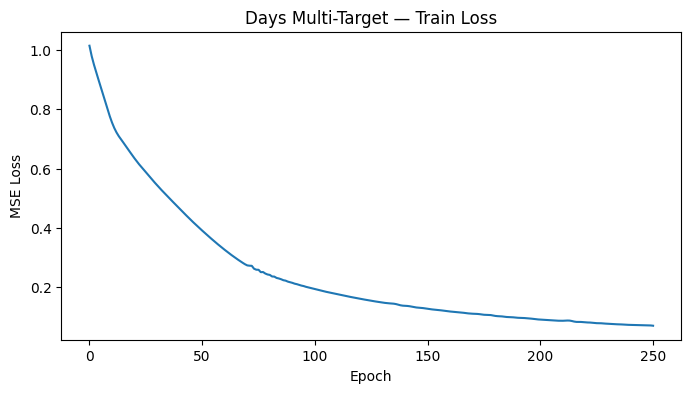

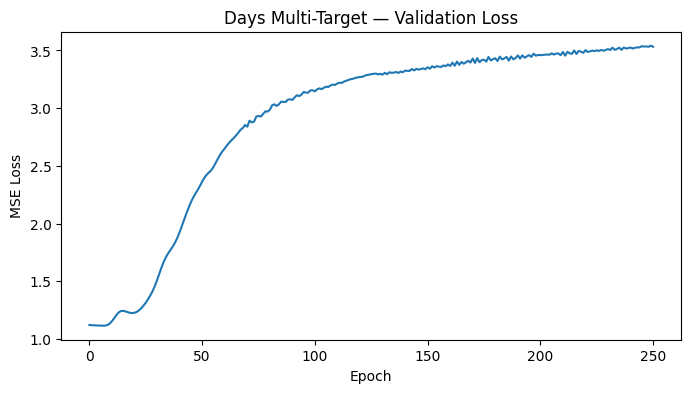

In [26]:
plt.figure(figsize=(8,4))
plt.plot(train_losses_days_mt)
plt.title("Days Multi-Target — Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_losses_days_mt)
plt.title("Days Multi-Target — Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

# Real vs Predictions

In [27]:
# convert validation sets to tensors
X_val_years_mt_t = torch.tensor(X_val_years_mt, dtype=torch.float32)
X_val_days_mt_t  = torch.tensor(X_val_days_mt,  dtype=torch.float32)

# ground truth arrays
real_years_mt = Y_val_years_mt.copy()
real_days_mt  = Y_val_days_mt.copy()

# get predictions
model_years_mt.eval()
model_days_mt.eval()

with torch.no_grad():
    pred_years_mt = model_years_mt(X_val_years_mt_t).cpu().numpy()
    pred_days_mt  = model_days_mt(X_val_days_mt_t).cpu().numpy()

In [28]:
WVHT_IDX = target_cols_years.index("WVHT")

real_years_wvht = real_years_mt[:, WVHT_IDX]
real_days_wvht  = real_days_mt[:, WVHT_IDX]

pred_years_wvht = pred_years_mt[:, WVHT_IDX]
pred_days_wvht  = pred_days_mt[:, WVHT_IDX]

In [29]:
plot_len = 336  # 7 days × 48 samples/day

real_7       = real_days_wvht[:plot_len]
pred_days_7  = pred_days_wvht[:plot_len]
pred_years_7 = pred_years_wvht[:plot_len]

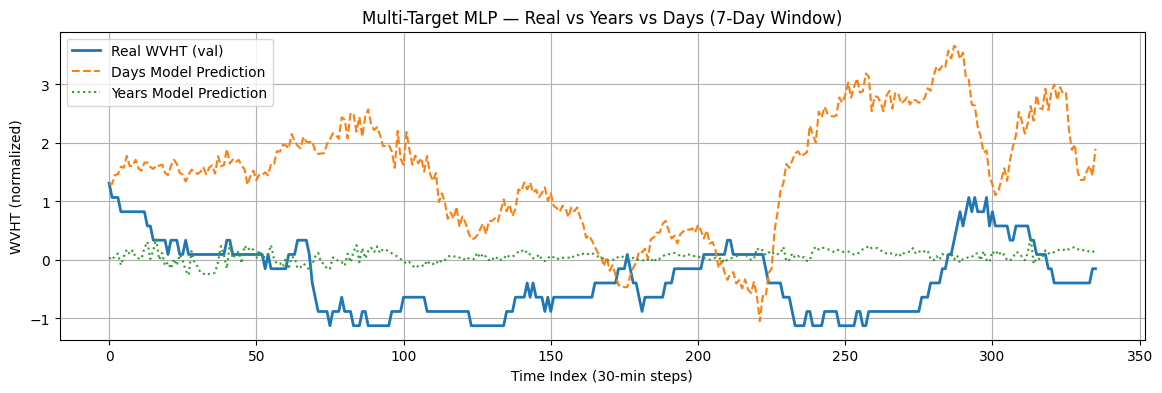

In [30]:
plt.figure(figsize=(14,4))

plt.plot(real_7,       label="Real WVHT (val)", linewidth=2)
plt.plot(pred_days_7,  label="Days Model Prediction", linestyle="--")
plt.plot(pred_years_7, label="Years Model Prediction", linestyle=":")

plt.title("Multi-Target MLP — Real vs Years vs Days (7-Day Window)")
plt.xlabel("Time Index (30-min steps)")
plt.ylabel("WVHT (normalized)")
plt.grid(True)
plt.legend()
plt.show()